In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.externals import joblib

In [2]:
from metricas import mape, pocid

In [8]:
from sklearn.metrics import mean_squared_error as MSE

In [3]:
from preprocessamento import *

In [4]:
serie_name = 'star'
print('Série:', serie_name)
endereco = serie_name+'.txt'
dados = pd.read_csv(endereco, delimiter=' ', header=None)
serie = dados[0]
serie_normalizada = normalise(serie)

train, test = split_serie_less_lags(serie_normalizada, 0.75)

max_lag = 20
lags_acf = select_lag_acf(serie_normalizada, max_lag)
max_sel_lag = lags_acf[0]

train_lags = create_windows(train, max_sel_lag+1)

test_data = create_windows(test, max_sel_lag+1)

train_data,  val_data = select_validation_sample(train_lags, 0.34)

Série: star
LAGS [0, 1, 2, 3, 4, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]


In [5]:
x_train = train_data[:,0:-1]
x_train = x_train[:,lags_acf]  #retorna só os lags selecionados no acf
y_train = train_data[:,-1]
x_val = val_data[:,0:-1]
x_val = x_val[:,lags_acf]
y_val = val_data[:,-1]
x_test = test_data[:,lags_acf]
y_test = test_data[:,-1]

In [6]:
def gerar_svr(k, g, e, c):
    from sklearn.svm import SVR
    svr = SVR(kernel=k,gamma=g, epsilon=e, C=c )
    return svr

In [7]:
def train_modelo(modelo, x_train, y_train, x_val, y_val, num_ex=5):

    melhor_mse = np.Inf
    for i in range(0, num_ex):
        modelo.fit(x_train, y_train)
        prev_v = modelo.predict(x_val)
        novo_mse  = MSE(y_val, prev_v)
        if novo_mse < melhor_mse:
            melhor_mse = novo_mse
            melhor_modelo = modelo

    return melhor_modelo, melhor_mse

In [9]:
kernel =['sigmoid'] #['sigmoid', 'rbf']
gamma =  [0.5]  #[0.5, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 400, 600, 800, 1000]
eps =  [1] #[1, 0.1,0.001, 0.0001, 0.00001, 0.000001]
C =  [0.1]  #[0.1, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
num_sel_lag = 0
best_result = np.Inf

for k in kernel:
    for g in gamma:
        for e in eps:
            for c in C:

                svr = gerar_svr(k,g,e, c)
                modelo_treinado, mse_val = train_modelo(svr, x_train, y_train, x_val, y_val, num_ex=1)
                if mse_val < best_result:
                    best_result = mse_val
                    select_model = modelo_treinado

In [10]:
filename = serie_name+'_SVR_aula.sav'
joblib.dump(select_model, filename)

['star_SVR_aula.sav']

In [11]:
nome_modelo = filename
modelo_carregado = joblib.load(nome_modelo)

In [12]:
prev_test = modelo_carregado.predict(x_test)

In [13]:
pocid(y_test, prev_test)

0.0

In [14]:
mape(y_test, prev_test)

100.46190970956559

In [16]:
MSE(y_test, prev_test)

0.06391995922856146

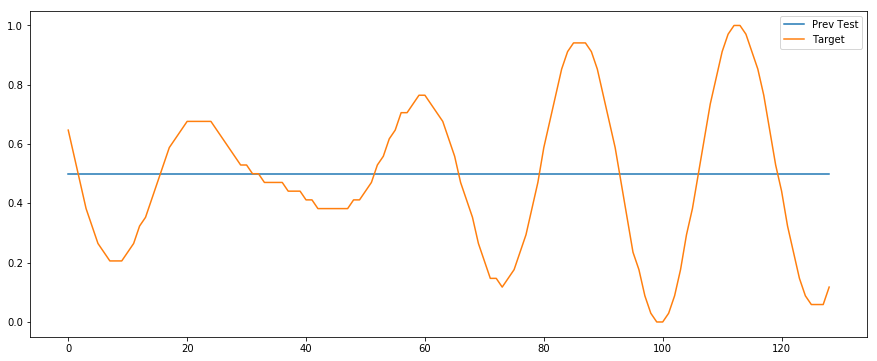

In [17]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] =15, 6


plt.plot(prev_test, label = 'Prev Test')
plt.plot(y_test, label='Target')
plt.legend(loc='best')
plt.show()